In [264]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pdb

import time
import pylab as pl
from IPython import display

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import copy
import math

from cubic_spline_planner import CubicSpline2D

In [265]:
class quintic_polynomial:

    # __init__ is a reseved method in python classes. It is known as a constructor in object oriented concepts. 
    # This method called when an object is created from the class and it allow the class to initialize the attributes of a class.
    def __init__(self, xs, vxs, axs, xe, vxe, axe, T):
        """
        Args:
        
        xs : initial position
        vxs : initial velocity
        axs : initial acceleration
        xe : end position
        vxe : end velocity
        axe : end acceleration
        T : tme to go to end position

        """

        # calc coefficient of quintic polynomial
        self.xs = xs
        self.vxs = vxs
        self.axs = axs
        self.xe = xe
        self.vxe = vxe
        self.axe = axe

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[T**3, T**4, T**5],
                      [3 * T ** 2, 4 * T ** 3, 5 * T ** 4],
                      [6 * T, 12 * T ** 2, 20 * T ** 3]])
        b = np.array([xe - self.a0 - self.a1 * T - self.a2 * T**2,
                      vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]
        self.a5 = x[2]

    def calc_point(self, t):                             # position w.r.t time
        xt = self.a0 + self.a1 * t + self.a2 * t**2 + \
            self.a3 * t**3 + self.a4 * t**4 + self.a5 * t**5

        return xt

    def calc_first_derivative(self, t):                  # velocity w.r.t time
        xt = self.a1 + 2 * self.a2 * t + \
            3 * self.a3 * t**2 + 4 * self.a4 * t**3 + 5 * self.a5 * t**4

        return xt

    def calc_second_derivative(self, t):                   # acceleration w.r.t time      
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t**2 + 20 * self.a5 * t**3

        return xt

    def calc_third_derivative(self, t):                       # jerk w.r.t time
        xt = 6 * self.a3 + 24 * self.a4 * t + 60 * self.a5 * t**2

        return xt

In [266]:
class quartic_polynomial:

    def __init__(self, xs, vxs, axs, vxe, axe, T):

        """
        Args:
            xs: Initial position (m)
            vxs: Initial velocity (m/s)
            axs: Initial acceleration (m/s^2)
            vxe: Final velocity (m/s)
            axe: Final acceleration (m/s^2)
            time: Time to reach the final state (s)
        """

        # calc coefficient of quintic polynomial
        self.xs = xs
        self.vxs = vxs
        self.axs = axs
        self.vxe = vxe
        self.axe = axe

        self.a0 = xs
        self.a1 = vxs
        self.a2 = axs / 2.0

        A = np.array([[3 * T ** 2, 4 * T ** 3],
                      [6 * T, 12 * T ** 2]])
        b = np.array([vxe - self.a1 - 2 * self.a2 * T,
                      axe - 2 * self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]

    def calc_point(self, t):                           # position w.r.t time
        xt = self.a0 + self.a1 * t + self.a2 * t**2 + \
            self.a3 * t**3 + self.a4 * t**4

        return xt

    def calc_first_derivative(self, t):          # velocity w.r.t time
        xt = self.a1 + 2 * self.a2 * t + \
            3 * self.a3 * t**2 + 4 * self.a4 * t**3

        return xt

    def calc_second_derivative(self, t):      # acceleration w.r.t time
        xt = 2 * self.a2 + 6 * self.a3 * t + 12 * self.a4 * t**2

        return xt

    def calc_third_derivative(self, t):        # jerk w.r.t time
        xt = 6 * self.a3 + 24 * self.a4 * t

        return xt

In [267]:
class Frenet_path:

    def __init__(self):

        """
        t : time
        d : lateral distance
        d_d : lateral velocity
        d_dd : lateral acceleration
        d_ddd : lateral jerk
        s : longitudinal distance
        s_d : longitudinal velocity
        s_dd : longitudinal acceleration
        s_ddd : longitudinal jerk
        cd : lateral cost
        cv : velocity cost
        cf: total cost of frenet path

        x : x position
        y : y position
        yaw : yaw angle
        ds : arc length distance
        c : curvature

        """
        self.t = []
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        self.cd = 0.0
        self.cv = 0.0
        self.cf = 0.0

        self.x = []
        self.y = []
        self.yaw = []
        self.ds = []
        self.c = []

In [268]:
# Parameter
MAX_SPEED = 25.0 / 3.6  # maximum speed [m/s]
MAX_ACCEL = 2.5  # maximum acceleration [m/ss]
MAX_CURVATURE = 1.0  # maximum curvature [1/m]
MAX_ROAD_WIDTH = 4  # maximum road width [m]
D_ROAD_W = 0.5  # road width sampling length [m]
DT = 0.2  # time tick [s]
MAXT = 4.0  # max prediction time [m]
MINT = 1.0  # min prediction time [m]
TARGET_SPEED = 8.0 / 3.6  # target speed [m/s]
D_T_S = 2.0 / 3.6  # target speed sampling length [m/s]
N_S_SAMPLE = 1 # sampling number of target speed
ROBOT_RADIUS = 2.0  # robot radius [m]

# cost weights

"""
KJ: Cost weights of jerk
KT: Cost weights of time
KD: Cost weights of square of derivative of lateral direction
KLAT: Cost weights of lateral direction
KLON: Cost weights of longitudinal direction
"""
KJ = 0.1
KT = 0.1
KD = 1.0
KLAT = 1.0
KLON = 5.0

In [269]:
def calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0):
    """
    Args:
        c_speed: current speed
        c_d: current lateral position
        c_d_d: current lateral speed
        c_d_dd: current lateral acceleration
        s0: current longitudinal position
    """
    # Empty list for frenet paths initialized
    frenet_paths = []

    # generate path to each offset goal
    for di in np.arange(-MAX_ROAD_WIDTH , MAX_ROAD_WIDTH, D_ROAD_W):  # _MAX_ROAD_WIDTH to MAX_ROAD_WIDTH with D_ROAD_W step

        # Lateral motion planning
        for Ti in np.arange(MINT, MAXT, DT):                           # MINT to MAXT with DT step
            fp = Frenet_path()

            lat_qp = quintic_polynomial(c_d, c_d_d, c_d_dd, di, 0.0, 0.0, Ti)

            fp.t = [t for t in np.arange(0.0, Ti, DT)]
            fp.d = [lat_qp.calc_point(t) for t in fp.t]
            fp.d_d = [lat_qp.calc_first_derivative(t) for t in fp.t]
            fp.d_dd = [lat_qp.calc_second_derivative(t) for t in fp.t]
            fp.d_ddd = [lat_qp.calc_third_derivative(t) for t in fp.t]

            # Loongitudinal motion planning (Velocity keeping)
            for tv in np.arange(TARGET_SPEED - D_T_S * N_S_SAMPLE, TARGET_SPEED + D_T_S * N_S_SAMPLE, D_T_S):
                tfp = copy.deepcopy(fp)
                # import pdb; pdb.set_trace()
                lon_qp = quartic_polynomial(s0, c_speed, 0.0, tv, 0.0, Ti)

                tfp.s = [lon_qp.calc_point(t) for t in fp.t]
                tfp.s_d = [lon_qp.calc_first_derivative(t) for t in fp.t]
                tfp.s_dd = [lon_qp.calc_second_derivative(t) for t in fp.t]
                tfp.s_ddd = [lon_qp.calc_third_derivative(t) for t in fp.t]

                Jp = sum(np.power(tfp.d_ddd, 2))  # square of jerk
                Js = sum(np.power(tfp.s_ddd, 2))  # square of jerk

                # square of diff from target speed
                ds = (TARGET_SPEED - tfp.s_d[-1])**2

                tfp.cd = KJ * Jp + KT * Ti + KD * tfp.d[-1]**2
                tfp.cv = KJ * Js + KT * Ti + KD * ds
                tfp.cf = KLAT * tfp.cd + KLON * tfp.cv

                frenet_paths.append(tfp)

    return frenet_paths

In [270]:

faTrajX = []
faTrajY = []

def calc_global_paths(fplist, csp):

    #faTrajX = []
    #faTrajY = []

    for fp in fplist:

        # calc global positions
        for i in range(len(fp.s)):
            ix, iy = csp.calc_position(fp.s[i])
            if ix is None:
                break
            iyaw = csp.calc_yaw(fp.s[i])
            di = fp.d[i]
            fx = ix + di * math.cos(iyaw + math.pi / 2.0)
            fy = iy + di * math.sin(iyaw + math.pi / 2.0)
            fp.x.append(fx)
            fp.y.append(fy)

        # Just for plotting
        faTrajX.append(fp.x)
        faTrajY.append(fp.y)
        
        # calc yaw and ds
        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(math.atan2(dy, dx))
            fp.ds.append(math.sqrt(dx**2 + dy**2))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            fp.c.append((fp.yaw[i + 1] - fp.yaw[i]) / fp.ds[i])

    return fplist

In [271]:
faTrajCollisionX = []
faTrajCollisionY = []
faObCollisionX = []
faObCollisionY = []

def check_collision(fp, ob):
    #pdb.set_trace()
    for i in range(len(ob[:, 0])):
        # Calculate the distance for each trajectory point to the current object
        d = [((ix - ob[i, 0])**2 + (iy - ob[i, 1])**2)
             for (ix, iy) in zip(fp.x, fp.y)]

        # Check if any trajectory point is too close to the object using the robot radius
        collision = any([di <= ROBOT_RADIUS**2 for di in d])

        if collision:
            #plot(ft.x, ft.y, 'rx')
            faTrajCollisionX.append(fp.x)
            faTrajCollisionY.append(fp.y)
            
            #plot(ox, oy, 'yo');
            #pdb.set_trace()
            if ob[i, 0] not in faObCollisionX or ob[i, 1] not in faObCollisionY:
                faObCollisionX.append(ob[i, 0])
                faObCollisionY.append(ob[i, 1])
            
            
            return True

    return False

In [272]:
#faTrajOkX = []
#faTrajOkY = []

def check_paths(fplist, ob):

    okind = []
    for i in range(len(fplist)):
        if any([v > MAX_SPEED for v in fplist[i].s_d]):  # Max speed check
            continue
        # elif any([abs(a) > MAX_ACCEL for a in fplist[i].s_dd]):  # Max accel check
        #     continue
        # elif any([abs(c) > MAX_CURVATURE for c in fplist[i].c]):  # Max curvature check
        #     continue
        elif check_collision(fplist[i], ob):
            continue

        okind.append(i)

    return [fplist[i] for i in okind]

In [273]:
fpplist = []

def frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob):
    #pdb.set_trace()
    fplist = calc_frenet_paths(c_speed, c_d, c_d_d, c_d_dd, s0)
    fplist = calc_global_paths(fplist, csp)
    fplist = check_paths(fplist, ob)
    
    #fpplist = deepcopy(fplist)
    fpplist.extend(fplist)

    # find minimum cost path
    mincost = float("inf")
    bestpath = None
    for fp in fplist:
        if mincost >= fp.cf:
            mincost = fp.cf
            bestpath = fp

    return bestpath

In [274]:
from cubic_spline_planner import *
def generate_target_course(x, y):
    csp = CubicSpline2D(x, y)
    s = np.arange(0, csp.s[-1], 0.1)
    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(csp.calc_yaw(i_s))
        rk.append(csp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, csp

In [275]:
show_animation = True
#show_animation = False

In [276]:
import pandas as pd

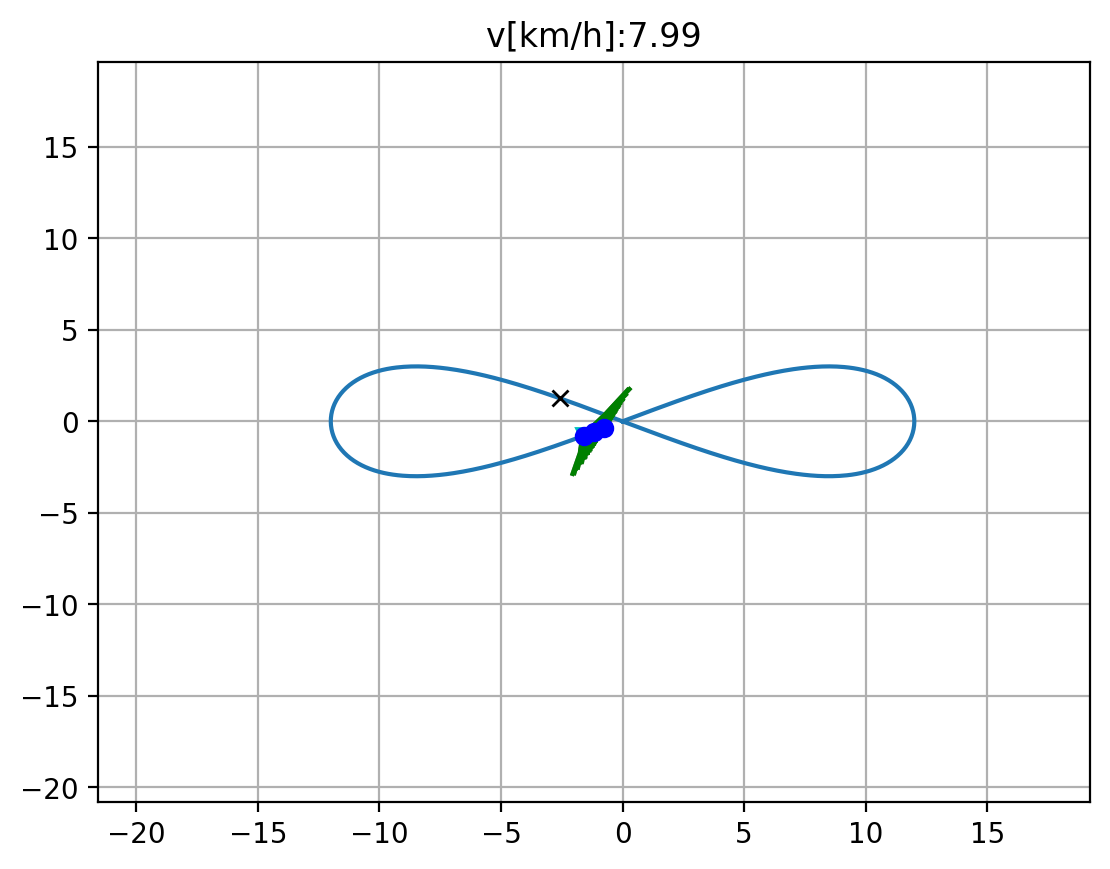

arc length at i =  143  is  55.72095355457366
Goal


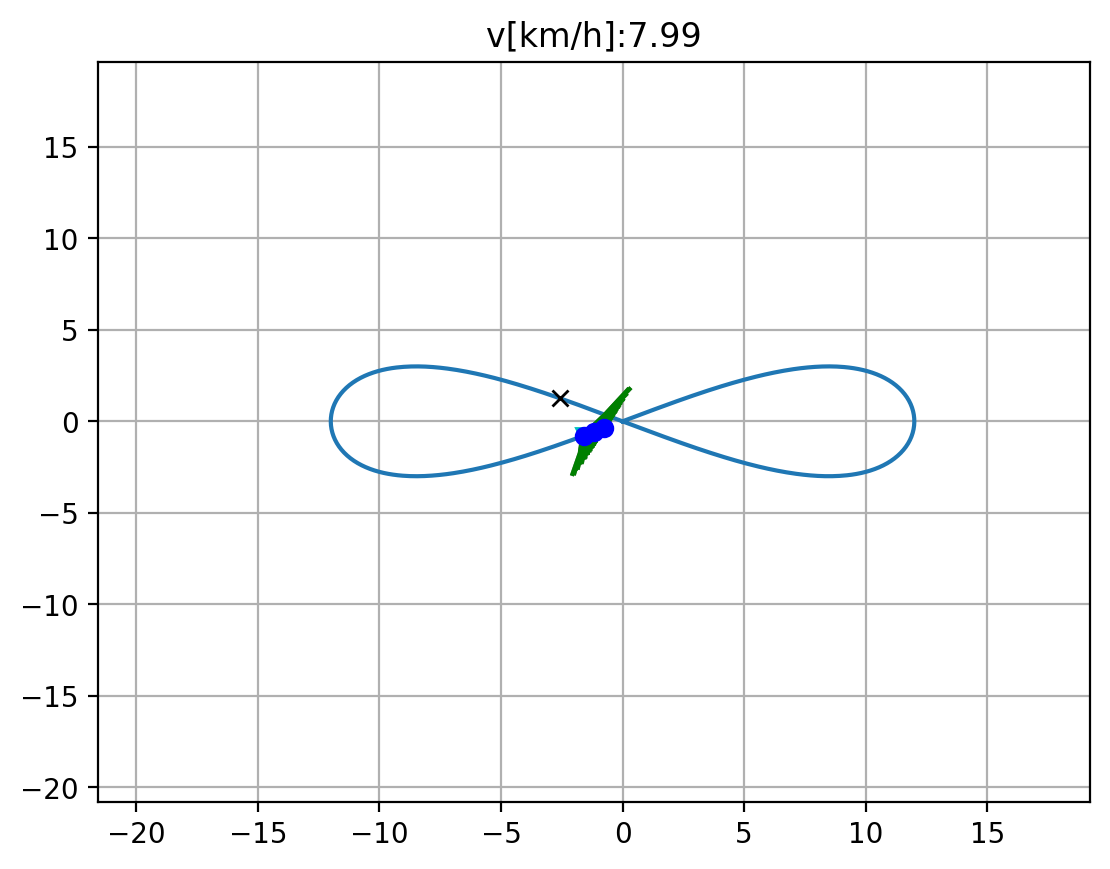

In [277]:
# way points
df = pd.read_csv('eight_shaped_road.csv')
wx = df['x'].values
wy = df['y'].values

# sin wave waypoints
# wx = np.arange(0, 100, 0.1) 
# wy = np.cos(2 * np.pi *1* wx/10)
plt.plot(wx, wy)
plt.show()

# wx = [0.0, 10.0, 20.5, 35.0, 70.5, 80, 90, 95, 100]
# wy = [0.0, -6.0, 5.0, 6.5, 0.0, -7.0, -6.0, -3.0, 0.0] 
# # obstacle lists
# ob = np.array([[20.0, 10.0],
#                [30.0, 6.0],
#                [30.0, 8.0],
#                [35.0, 8.0],
#                [50.0, 3.0]
#                ])

ob = np.array([[-2.5796, 1.2596]
               ])
tx, ty, tyaw, tc, csp = generate_target_course(wx, wy)

# initial state
c_speed = 5.0 / 3.6  # current speed [m/s]
c_d = 0.0  # current lateral position [m]
c_d_d = 0.0  # current lateral speed [m/s]
c_d_dd = 0.0  # current latral acceleration [m/s]
s0 = 0.0  # current course position

area = 10.0  # animation area length [m]

fig = plt.figure()

faTx = tx
faTy = ty
faObx = ob[:, 0]
faOby = ob[:, 1]
faPathx = []
faPathy = []
faRobotx = []
faRoboty = []
faSpeed = []

for i in range(150):
    path = frenet_optimal_planning(csp, s0, c_speed, c_d, c_d_d, c_d_dd, ob)

    s0 = path.s[1]
    c_d_d = path.d_d[1]
    c_d_dd = path.d_dd[1]
    c_speed = path.s_d[1]

    if csp.s[-1] - s0 <= 0.5:
        print("Goal")
        break
    


    faPathx.append(path.x[1:])
    faPathy.append(path.y[1:])
    faRobotx.append(path.x[1])
    faRoboty.append(path.y[1])
    faSpeed.append(c_speed)
    
    
    if show_animation:
        plt.cla()
        plt.plot(tx, ty, animated=True)
        plt.plot(ob[:, 0], ob[:, 1], "xk")
        
        plt.plot(path.x[1], path.y[1], "vc")
        
        for (ix, iy) in zip(faTrajX, faTrajY):
            #pdb.set_trace()
            plt.plot(ix[1:], iy[1:], '-', color=[0.5, 0.5, 0.5])
        faTrajX = []
        faTrajY = []
        
        for (ix, iy) in zip(faTrajCollisionX, faTrajCollisionY):
            #pdb.set_trace()
            plt.plot(ix[1:], iy[1:], 'rx')
        faTrajCollisionX = []
        faTrajCollisionY = []
        #pdb.set_trace()
        for fp in fpplist:
            #pdb.set_trace()
            plt.plot(fp.x[1:], fp.y[1:], '-g')
        fpplist = []
        
        #pdb.set_trace()
        for (ix, iy) in zip(faObCollisionX, faObCollisionY):
            #pdb.set_trace()
            plt.plot(ix, iy, 'oy')
        faObCollisionX = []
        faObCollisionY = []
        
        plt.plot(path.x[1:], path.y[1:], "-ob")
        
        plt.xlim(path.x[1] - area, path.x[-1] + area)
        plt.ylim(path.y[1] - area, path.y[-1] + area)
        plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
        plt.grid(True)
        #plt.pause(0.0001)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        

#print("Finish")
#if show_animation:
    #plt.grid(True)
    #plt.pause(0.0001)
    #plt.show()

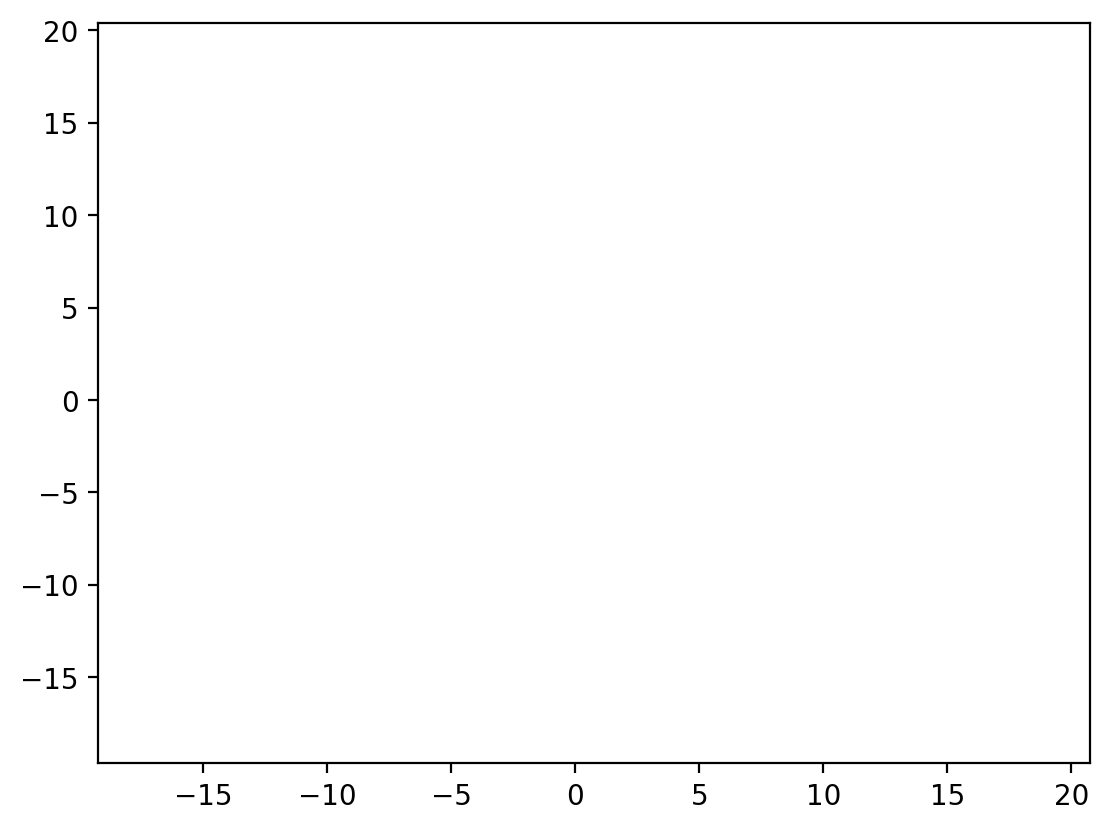

In [278]:
from matplotlib import animation

fig, ax = plt.subplots();

ax.set_xlim((faPathx[1][1] - area, faPathx[1][1] + area))
ax.set_ylim((faPathy[1][1] - area, faPathy[1][1] + area))

h_ref = ax.plot([], [], "-b") # reference path
h_obstacles = ax.plot([], [], "xk") #obstacles to animate
h_path = ax.plot([], [], "-or") # trajectory to animate
h_car = ax.plot([], [], "vc")


patches = list(h_obstacles) + list(h_path) + list(h_ref) + list(h_car) #things to animate

In [279]:
def init():
    #init lines
    h_ref[0].set_data(faTx, faTy)
    
    h_obstacles[0].set_data(faObx, faOby)
    
    h_path[0].set_data([], [])
    
    h_car[0].set_data([], [])
    
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    ax.grid(True)
    
    
    return patches #return everything that must be updated

In [280]:
# animation function. This is called sequentially
def animate(i):


    ax.set_xlim((faPathx[i][1] - area, faPathx[i][1] + area))
    ax.set_ylim((faPathy[i][1] - area, faPathy[i][1] + area))


    h_path[0].set_data(faPathx[i], faPathy[i])

    h_car[0].set_data(faRobotx[i], faRoboty[i])
    
    
    ax.set_title("v[km/h]:" + str(faSpeed[i] * 3.6)[0:4], fontsize=12)

    return patches #return everything that must be updated

In [281]:
nFrames = len(faPathx)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nFrames, interval=50, blit=True)

plt.show()

In [282]:
from IPython.display import HTML
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available